In [1]:
import pandas as pd
import numpy as np

In [2]:
customers = pd.read_csv('../data/Customers.csv')
transactions = pd.read_csv('../data/Transactions.csv')

In [3]:
customers.columns

Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')

In [4]:
transactions.columns

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price'],
      dtype='object')

In [5]:
merged_data = pd.merge(customers, transactions, on="CustomerID", how="inner")

In [6]:
merged_data.isnull().sum()

CustomerID         0
CustomerName       0
Region             0
SignupDate         0
TransactionID      0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

In [7]:
merged_data.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64


In [8]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   object 
 1   CustomerName     1000 non-null   object 
 2   Region           1000 non-null   object 
 3   SignupDate       1000 non-null   object 
 4   TransactionID    1000 non-null   object 
 5   ProductID        1000 non-null   object 
 6   TransactionDate  1000 non-null   object 
 7   Quantity         1000 non-null   int64  
 8   TotalValue       1000 non-null   float64
 9   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 78.2+ KB


In [9]:
merged_data.describe()

,Quantity,TotalValue,Price
count,1000.000000,1000.000000,1000.00000
mean,2.537000,689.995560,272.55407
std,1.117981,493.144478,140.73639
min,1.000000,16.080000,16.08000
25%,2.000000,295.295000,147.95000
50%,3.000000,588.880000,299.93000
75%,4.000000,1011.660000,404.40000
max,4.000000,1991.040000,497.76000


We aggregate these metrics because they provide a comprehensive view of each customer's purchasing behavior, helping us group similar customers together

In [10]:
customer_transactions = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",  
    "Price": "mean",  
    "TransactionDate": "nunique",  # Purchase frequency
}).reset_index()

In [11]:
customer_transactions.head()

,CustomerID,TotalValue,Quantity,Price,TransactionDate
0,C0001,3354.52,12,278.334000,5
1,C0002,1862.74,10,208.920000,4
2,C0003,2725.38,14,195.707500,4
3,C0004,5354.88,23,240.636250,8
4,C0005,2034.24,7,291.603333,3


In [12]:
customer_transactions.isnull().sum()    

CustomerID         0
TotalValue         0
Quantity           0
Price              0
TransactionDate    0
dtype: int64

Merge with customer profile data

In [13]:
customer_profile = customers[["CustomerID", "Region"]]
customer_data = pd.merge(customer_transactions, customer_profile, on="CustomerID", how="left")

In [14]:
customer_data.head()

,CustomerID,TotalValue,Quantity,Price,TransactionDate,Region
0,C0001,3354.52,12,278.334000,5,South America
1,C0002,1862.74,10,208.920000,4,Asia
2,C0003,2725.38,14,195.707500,4,South America
3,C0004,5354.88,23,240.636250,8,South America
4,C0005,2034.24,7,291.603333,3,Asia


In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

Lable Encoding

In [16]:
label_encoder = LabelEncoder()
customer_data['Region'] = label_encoder.fit_transform(customer_data['Region'])

In [17]:
customer_data.head()

,CustomerID,TotalValue,Quantity,Price,TransactionDate,Region
0,C0001,3354.52,12,278.334000,5,3
1,C0002,1862.74,10,208.920000,4,0
2,C0003,2725.38,14,195.707500,4,3
3,C0004,5354.88,23,240.636250,8,3
4,C0005,2034.24,7,291.603333,3,0


feature scaling

In [18]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data.drop(columns=["CustomerID"]))

In [19]:
feature_names = customer_data.drop(columns=["CustomerID"]).columns

Clustering with K means

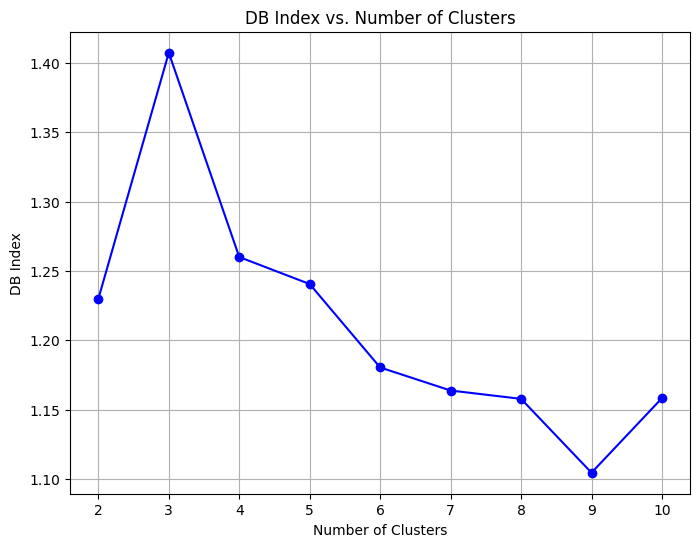

In [20]:
db_indexes = []

# Try clustering from 2 to 10 clusters
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
    db_indexes.append(db_index)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), db_indexes, marker='o', linestyle='-', color='b')
plt.title('DB Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

Lower DB index value is better

In [21]:
optimal_k = range(2, 11)[db_indexes.index(min(db_indexes))]
print(f"The optimal number of clusters is: {optimal_k}")

The optimal number of clusters is: 9


In [22]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42) 
customer_data["Cluster"] = kmeans.fit_predict(scaled_features)

DB index and Sillihoute score

In [23]:
db_index = davies_bouldin_score(scaled_features, customer_data["Cluster"])
sil_score = silhouette_score(scaled_features, customer_data["Cluster"])

In [24]:
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {sil_score}")

DB Index: 1.1045960672449628
Silhouette Score: 0.2497773857955792


Plot

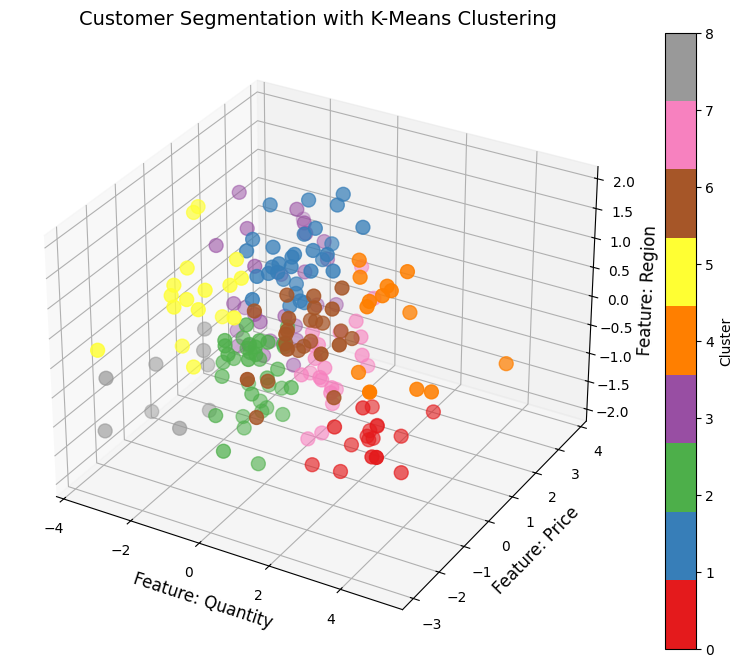

In [25]:
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)

top_features = [feature_names[abs(pca.components_[i]).argmax()] for i in range(3)]


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], pca_features[:, 2], 
                     c=customer_data["Cluster"], cmap='Set1', s=100)
ax.set_title("Customer Segmentation with K-Means Clustering", fontsize=14)
ax.set_xlabel(f"Feature: {top_features[0]}", fontsize=12)
ax.set_ylabel(f"Feature: {top_features[1]}", fontsize=12)
ax.set_zlabel(f"Feature: {top_features[2]}", fontsize=12)
plt.colorbar(scatter, label='Cluster')

plt.show()

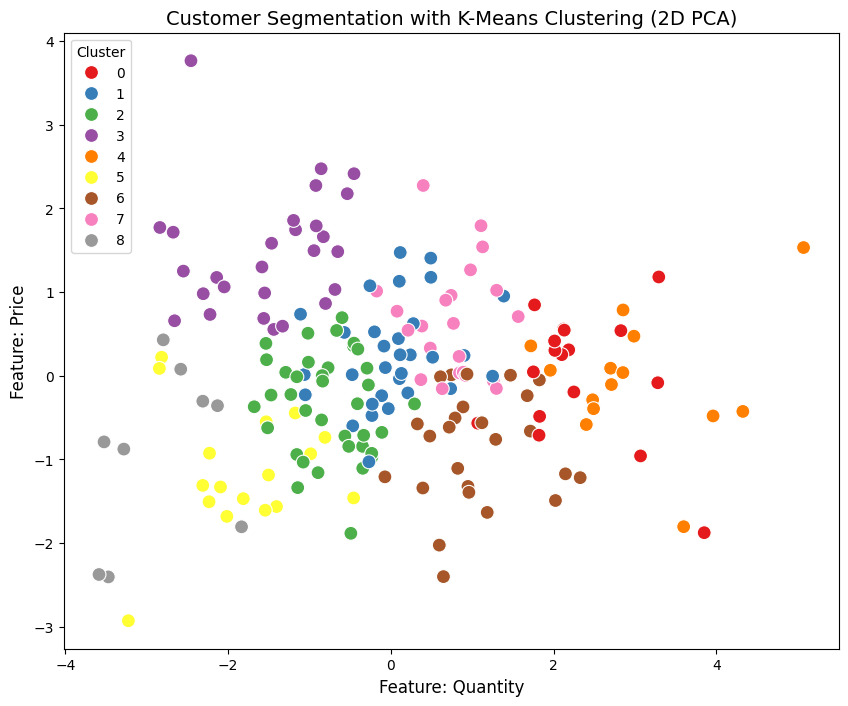

In [26]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

top_features = [feature_names[abs(pca.components_[i]).argmax()] for i in range(2)]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_data["Cluster"], palette="Set1", s=100)

plt.title("Customer Segmentation with K-Means Clustering (2D PCA)", fontsize=14)
plt.xlabel(f"Feature: {top_features[0]}", fontsize=12)
plt.ylabel(f"Feature: {top_features[1]}", fontsize=12)
plt.legend(title="Cluster")

plt.show()